In [2]:
%load_ext autoreload
%autoreload 2

# First test the valve control with fixed pump flow 

In [38]:
from datetime import datetime, timedelta
import random
from control.modules.thrusters import ThrustersControl, ThrustersParameters
from input_output.base import Stamped
from input_output.definitions.simulation import Boundary, Pcs, TemperatureBoundary, Thruster
from input_output.modules.thrusters import ThrustersSensorValues, ThrustersSimulationInputs, ThrustersSimulationOutputs
from orchestration.collector import PolarsCollector
from orchestration.executor import SimulationExecutor
from simulation.fmu import Fmu
from simulation.io_mapping import IoMapping
from simulation.models.fmu_paths import thrusters_path


simulation_inputs = ThrustersSimulationInputs(
        thrusters_aft=Thruster(
            heat_flow=Stamped.stamp(9000), active=Stamped.stamp(True)
        ),
        thrusters_fwd=Thruster(
            heat_flow=Stamped.stamp(4300), active=Stamped.stamp(True)
        ),
        thrusters_seawater_supply=Boundary(
            temperature=Stamped.stamp(32), flow=Stamped.stamp(10)
        ),
        thrusters_module_supply=TemperatureBoundary(temperature=Stamped.stamp(30)),
        thrusters_pcs=Pcs(mode=Stamped.stamp("propulsion")),
    )



In [ ]:
#set mix target temp below supply temp
control = ThrustersControl(
    ThrustersParameters(
        recovery_mix_target_temperature=30, recovery_flow_target_temperature=60, flowcontrol_valve_target_position=.95
    )
)


executor = SimulationExecutor(
    IoMapping(
        Fmu(thrusters_path),
        ThrustersSensorValues,
        ThrustersSimulationOutputs,
    ),
    simulation_inputs,
    datetime.fromtimestamp(0),
    timedelta(seconds=1),
)


result_collector = PolarsCollector()

#open mix valves
control._current_values.thrusters_mix_aft.setpoint = Stamped(
    value=1.0, timestamp=control._time
)

control._current_values.thrusters_mix_fwd.setpoint = Stamped(
    value=1.0, timestamp=control._time
)

result = await executor.tick(control._current_values)

random.seed(0)
for i in range(3000):
    control._time = executor.time()
    control_values = control.control(result.sensor_values, executor.time()).values

    #change fixed pump flow at regular interval
    if i % 600 == 0:
         dutypoint = random.uniform(0.15, .35)

    control_values.thrusters_pump_1.dutypoint.value = dutypoint

    result = await executor.tick(control_values)
    result_collector.collect(result.raw, control.mode, executor.time())

(<Figure size 1800x1000 with 4 Axes>,
 array([[<Axes: title={'center': 'Thrusters'}, xlabel='time', ylabel='Dutypoint [ratio]'>],
        [<Axes: xlabel='time', ylabel='Valve position [ratio]'>],
        [<Axes: xlabel='time', ylabel='Temperature [°C]'>],
        [<Axes: xlabel='time', ylabel='Flow [l/min]'>]], dtype=object))

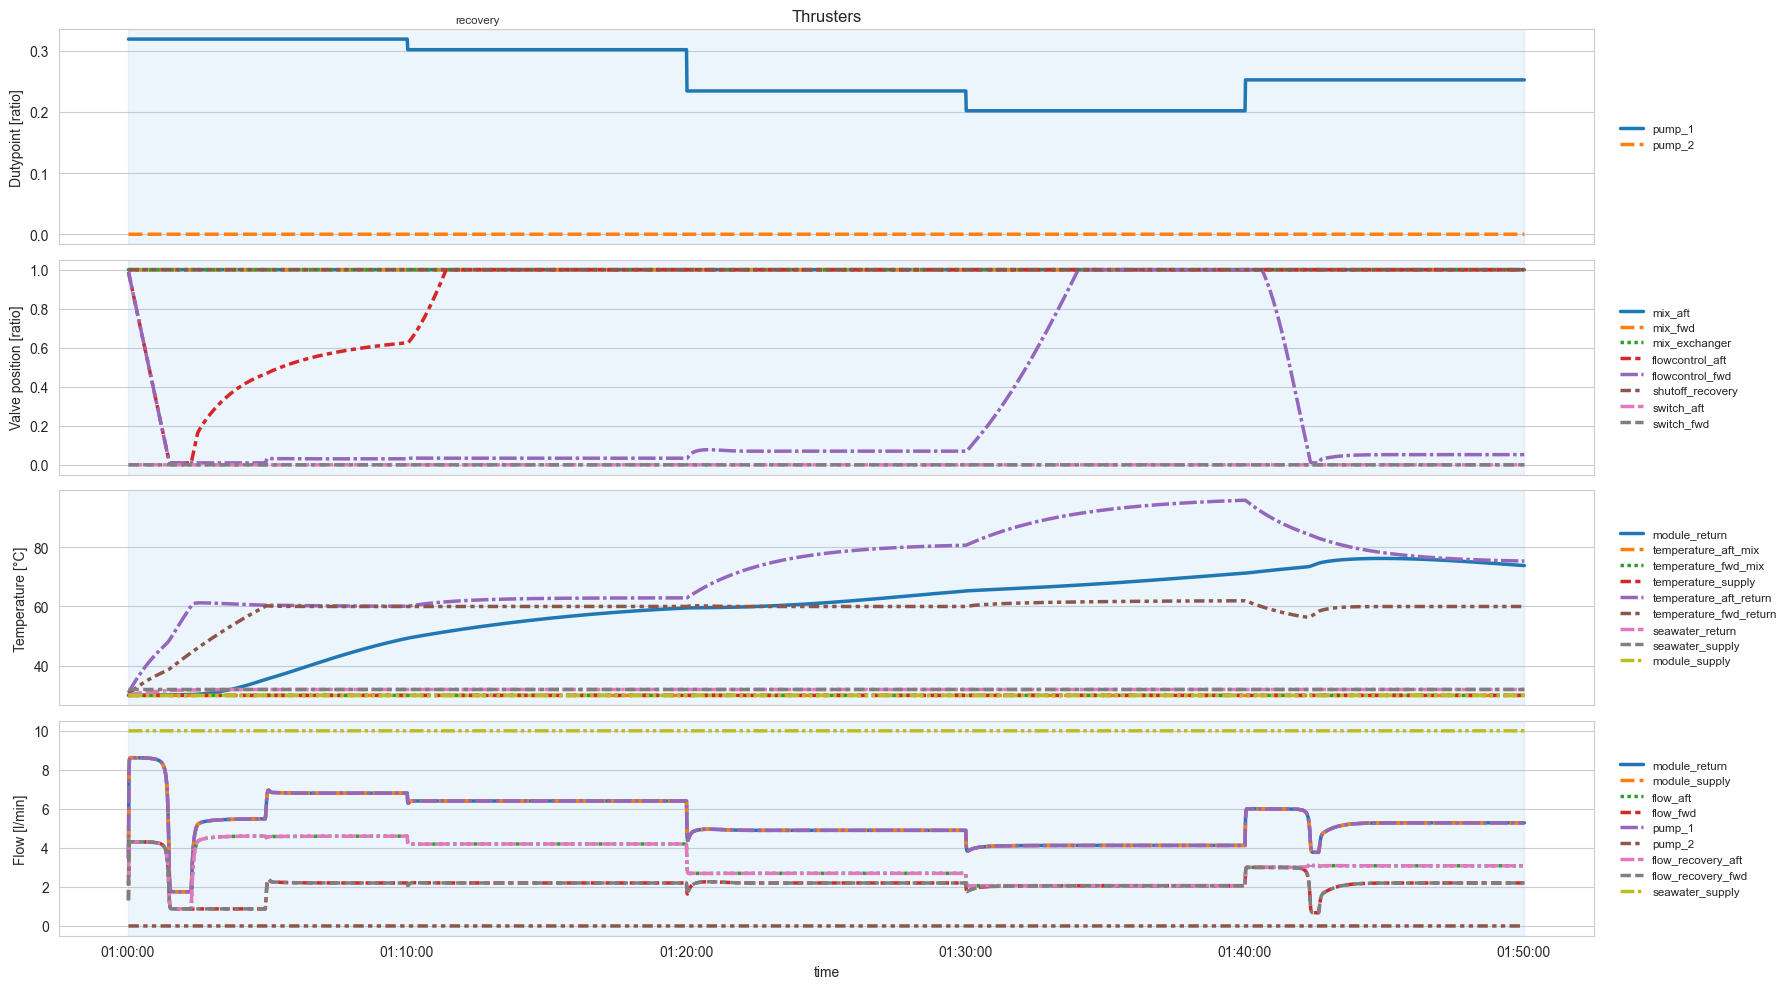

In [50]:
from analysis.analysis_utils import plot_result
from matplotlib import pyplot as plt

plot_result(result_collector.result(), 'plots/flowbasedtemp/valvecontrol.png')

## Now add pump control an vary setpoint 
- seems like it could work in principle, needs tuning.. 
- in particular the pump tuning. Need a large P to handle overshoot.. heuristic: increase P untill oscillating, then take half P and increase I to get rid of bias. 
- overshoots occur in the temperature of the aft thruster (the hottest). The valves operate in the right direction but are already fully open in that case. It is then up to the pump control to increase flow in order to force the valve back to the desired setpoint (.9). This is a slow reaction however, and the error is constrained since the valve has a max position of 1. This could thus only work in the pump control is such that operates fast enough to keep the flow valve that is most open fairly close to the setpoint (avoiding asymmetry in error). In other words, the pump control should be much faster in order to force the opened valve back to .95 when it is at 1... 
- requires more experimenting with tuning of pump control. It will be hard to tune this however, in particular in real life, due to the inrtoduced dependencies..
- It is a benefit that generally aft is expected to give much more power, meaning that generally the aft flow control should be doing all the work. This leads to another idea - namely setting up a control scheme with a single flow control valve. The pump regulates the temp o the thruster with most power, and the valve of the other regulates the power of the less powerful thruster. 
- In general we dont need the flowcontrol valve when only one thruster is active.


In [120]:
#set mix target temp below supply temp
control = ThrustersControl(
    ThrustersParameters(
        recovery_mix_target_temperature=30, recovery_flow_target_temperature=60, flowcontrol_valve_target_position=.95
    )
)


executor = SimulationExecutor(
    IoMapping(
        Fmu(thrusters_path),
        ThrustersSensorValues,
        ThrustersSimulationOutputs,
    ),
    simulation_inputs,
    datetime.fromtimestamp(0),
    timedelta(seconds=1),
)

result_collector = PolarsCollector()

#open mix valves
control._current_values.thrusters_mix_aft.setpoint = Stamped(
    value=1.0, timestamp=control._time
)

control._current_values.thrusters_mix_fwd.setpoint = Stamped(
    value=1.0, timestamp=control._time
)

result = await executor.tick(control._current_values)

random.seed(0)
setpoints = []
for i in range(3000):
    control._time = executor.time()

    #change temp setpoint at regular interval
    if i % 600 == 0:
        recovery_target_temperature = random.randint(40, 80)

    setpoints.append(recovery_target_temperature)
    control._aft_flow_controller.setpoint = recovery_target_temperature
    control._fwd_flow_controller.setpoint = recovery_target_temperature

    result = await executor.tick(control.control(result.sensor_values, executor.time()).values)
    result_collector.collect(result.raw, control.mode, executor.time())

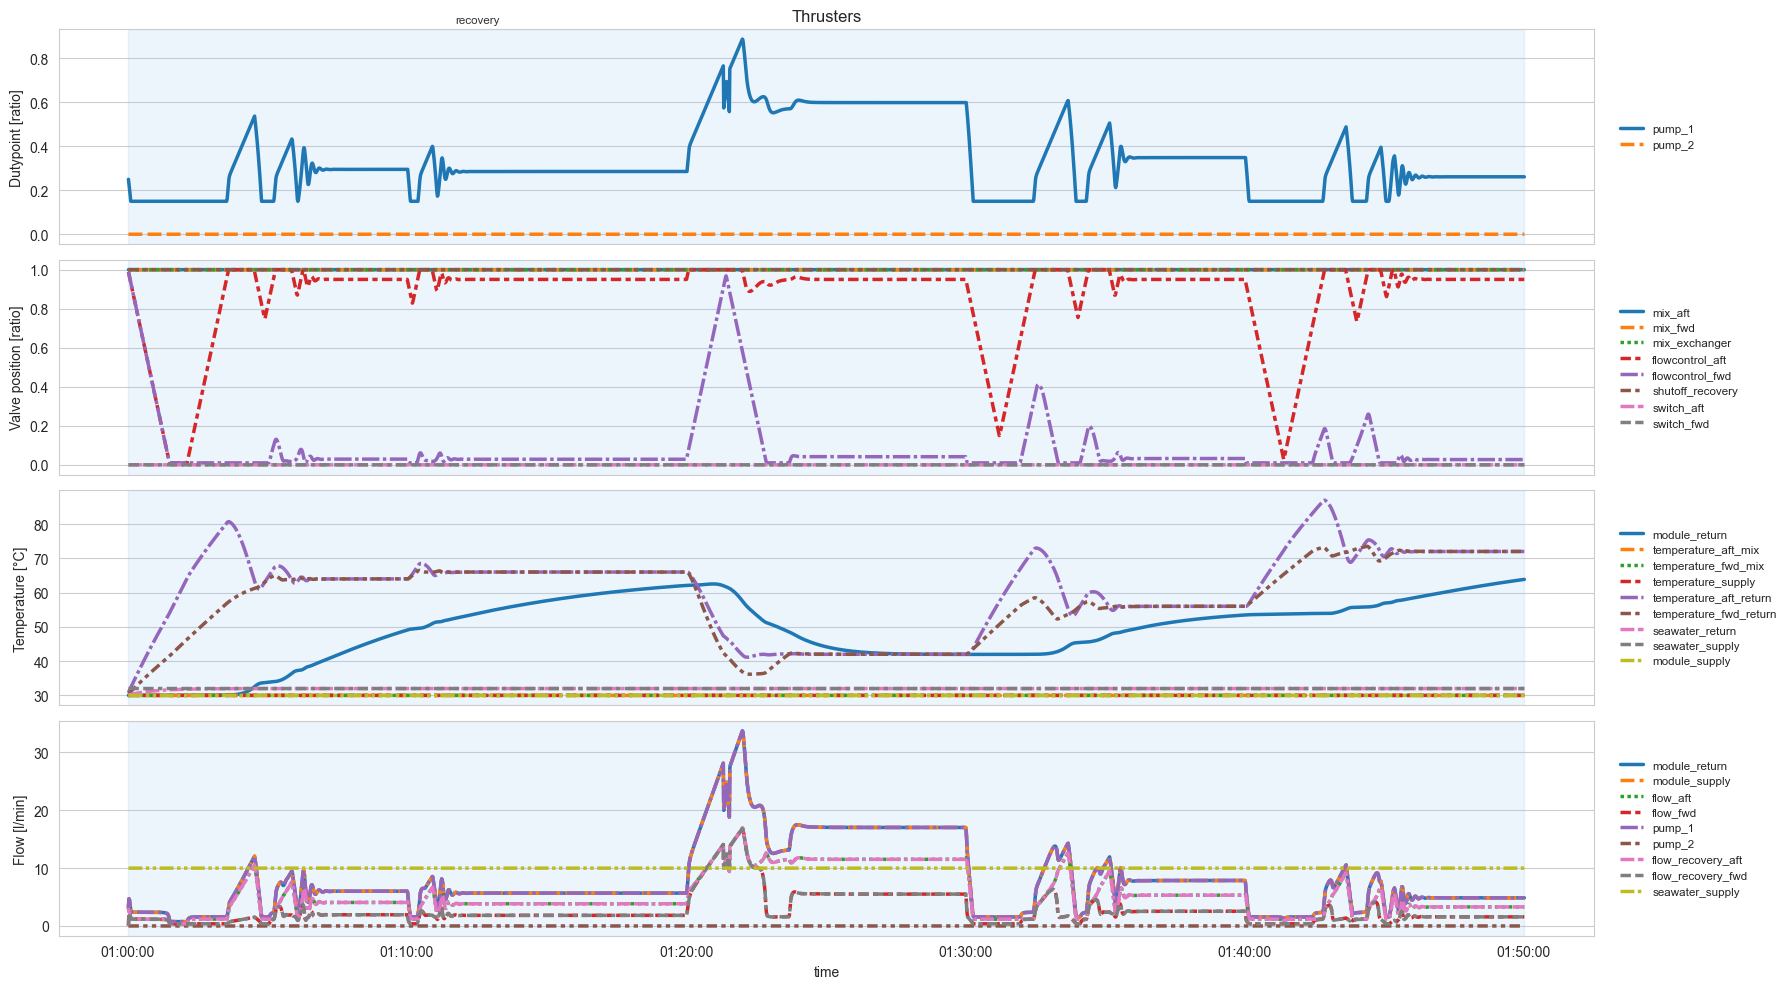

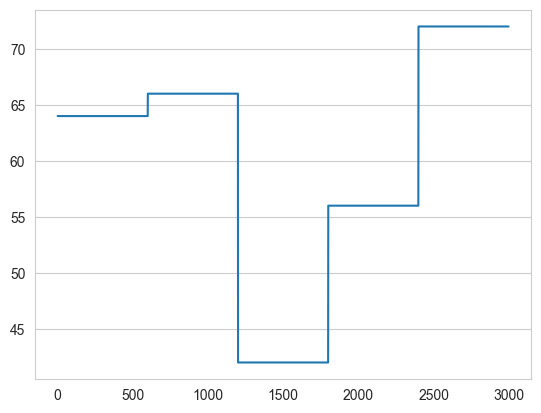

In [121]:
from analysis.analysis_utils import plot_result

plot_result(result_collector.result(), 'plots/flowbasedtemp/varyingsetpts.png')

plt.figure()
plt.plot(setpoints)

In [122]:
async def test_flow_balance(flow_control_tuning: tuple[float, float, float]):
    # set mix target temp below supply temp
    control = ThrustersControl(
        ThrustersParameters(
            recovery_mix_target_temperature=30,
            recovery_flow_target_temperature=60,
            flowcontrol_valve_target_position=0.95,
        )
    )

    executor = SimulationExecutor(
        IoMapping(
            Fmu(thrusters_path),
            ThrustersSensorValues,
            ThrustersSimulationOutputs,
        ),
        simulation_inputs,
        datetime.fromtimestamp(0),
        timedelta(seconds=1),
    )

    result_collector = PolarsCollector()

    # open mix valves
    control._current_values.thrusters_mix_aft.setpoint = Stamped(
        value=1.0, timestamp=control._time
    )

    control._current_values.thrusters_mix_fwd.setpoint = Stamped(
        value=1.0, timestamp=control._time
    )

    control._aft_flow_controller.tuning = flow_control_tuning
    control._fwd_flow_controller.tuning = flow_control_tuning

    result = await executor.tick(control._current_values)

    random.seed(0)
    setpoints = []
    for i in range(3000):
        control._time = executor.time()

        # change temp setpoint at regular interval
        if i % 600 == 0:
            recovery_target_temperature = random.randint(40, 80)

        setpoints.append(recovery_target_temperature)
        control._aft_flow_controller.setpoint = recovery_target_temperature
        control._fwd_flow_controller.setpoint = recovery_target_temperature

        result = await executor.tick(
            control.control(result.sensor_values, executor.time()).values
        )
        result_collector.collect(result.raw, control.mode, executor.time())

    return (
        flow_control_tuning,
        setpoints,
        result_collector.result()[
            "thrusters_temperature_aft_return__temperature__C"
        ].to_list(),
        result_collector.result()[
            "thrusters_temperature_fwd_return__temperature__C"
        ].to_list(),
        result_collector.result()["thrusters_flow_aft__flow__l_min"].to_list(),
        result_collector.result()["thrusters_flow_fwd__flow__l_min"].to_list(),
        result_collector.result()[
            "thrusters_flowcontrol_aft__setpoint__ratio"
        ].to_list(),
        result_collector.result()[
            "thrusters_flowcontrol_fwd__setpoint__ratio"
        ].to_list(),
        result_collector.result()[
            "thrusters_flowcontrol_aft__position_rel__ratio"
        ].to_list(),
        result_collector.result()[
            "thrusters_flowcontrol_fwd__position_rel__ratio"
        ].to_list(),
    )


In [123]:
tunings = [
     (-.5, -.0, -0.00),
     (-.1, -.01, -0.00),
     (-.1, -.001, -0.00),
     (-.01, -.01, -0.000),
]

results = [await test_flow_balance(tuning) for tuning in tunings]

In [124]:
def plot_flow_test(results: list):
    fig, axes = plt.subplots(
        3, len(results), figsize=(5 * len(results), 10), sharex=True
    )
    for i, result in enumerate(results):
        (
            flow_control_tuning,
            setpoints,
            aft_temperature,
            fwd_temperature,
            aft_flow,
            fwd_flow,
            aft_valve_setpoint,
            fwd_valve_setpoint,
            aft_valve_position,
            fwd_valve_position,
        ) = result

        axes[0, i].plot(setpoints, "--", label="temperature setpoint")
        axes[0, i].plot(aft_temperature, label="Aft temperature")
        axes[0, i].plot(fwd_temperature, label="Fwd temperature")

        axes[0, i].legend(loc="upper left", bbox_to_anchor=(1, 1))
        axes[0, i].set_title(f"{flow_control_tuning}")

        # total_error = sum(abs(aft_setpoint - aft_flow) + abs(fwd_setpoint - fwd_flow) for aft_setpoint, aft_flow, fwd_setpoint, fwd_flow in zip(aft_flow, fwd_flow, aft_flow_setpoints, fwd_flow_setpoints))

        # axes[0,i].text(1.02, 0.55, f'Total error: {total_error:.2f}', transform=axes[0,i].transAxes, fontsize=10, verticalalignment='top')
        axes[1, i].plot(aft_valve_setpoint, "--", label="Aft valve setpoint")
        axes[1, i].plot(fwd_valve_setpoint, "--", label="Fwd valve setpoint")
        axes[1, i].plot(aft_valve_position, label="Aft valve position")
        axes[1, i].plot(fwd_valve_position, label="Fwd valve position")
        axes[1, i].legend(loc="upper left", bbox_to_anchor=(1, 1))

        axes[2, i].plot(aft_flow,
            label="Aft flow",
        )
        axes[2, i].plot(fwd_flow,
            label="Fwd flow",
        )
        axes[2, i].legend(loc="upper left", bbox_to_anchor=(1, 1))

        axes[-1, i].set_xlabel("Time (s)")

        plt.tight_layout()


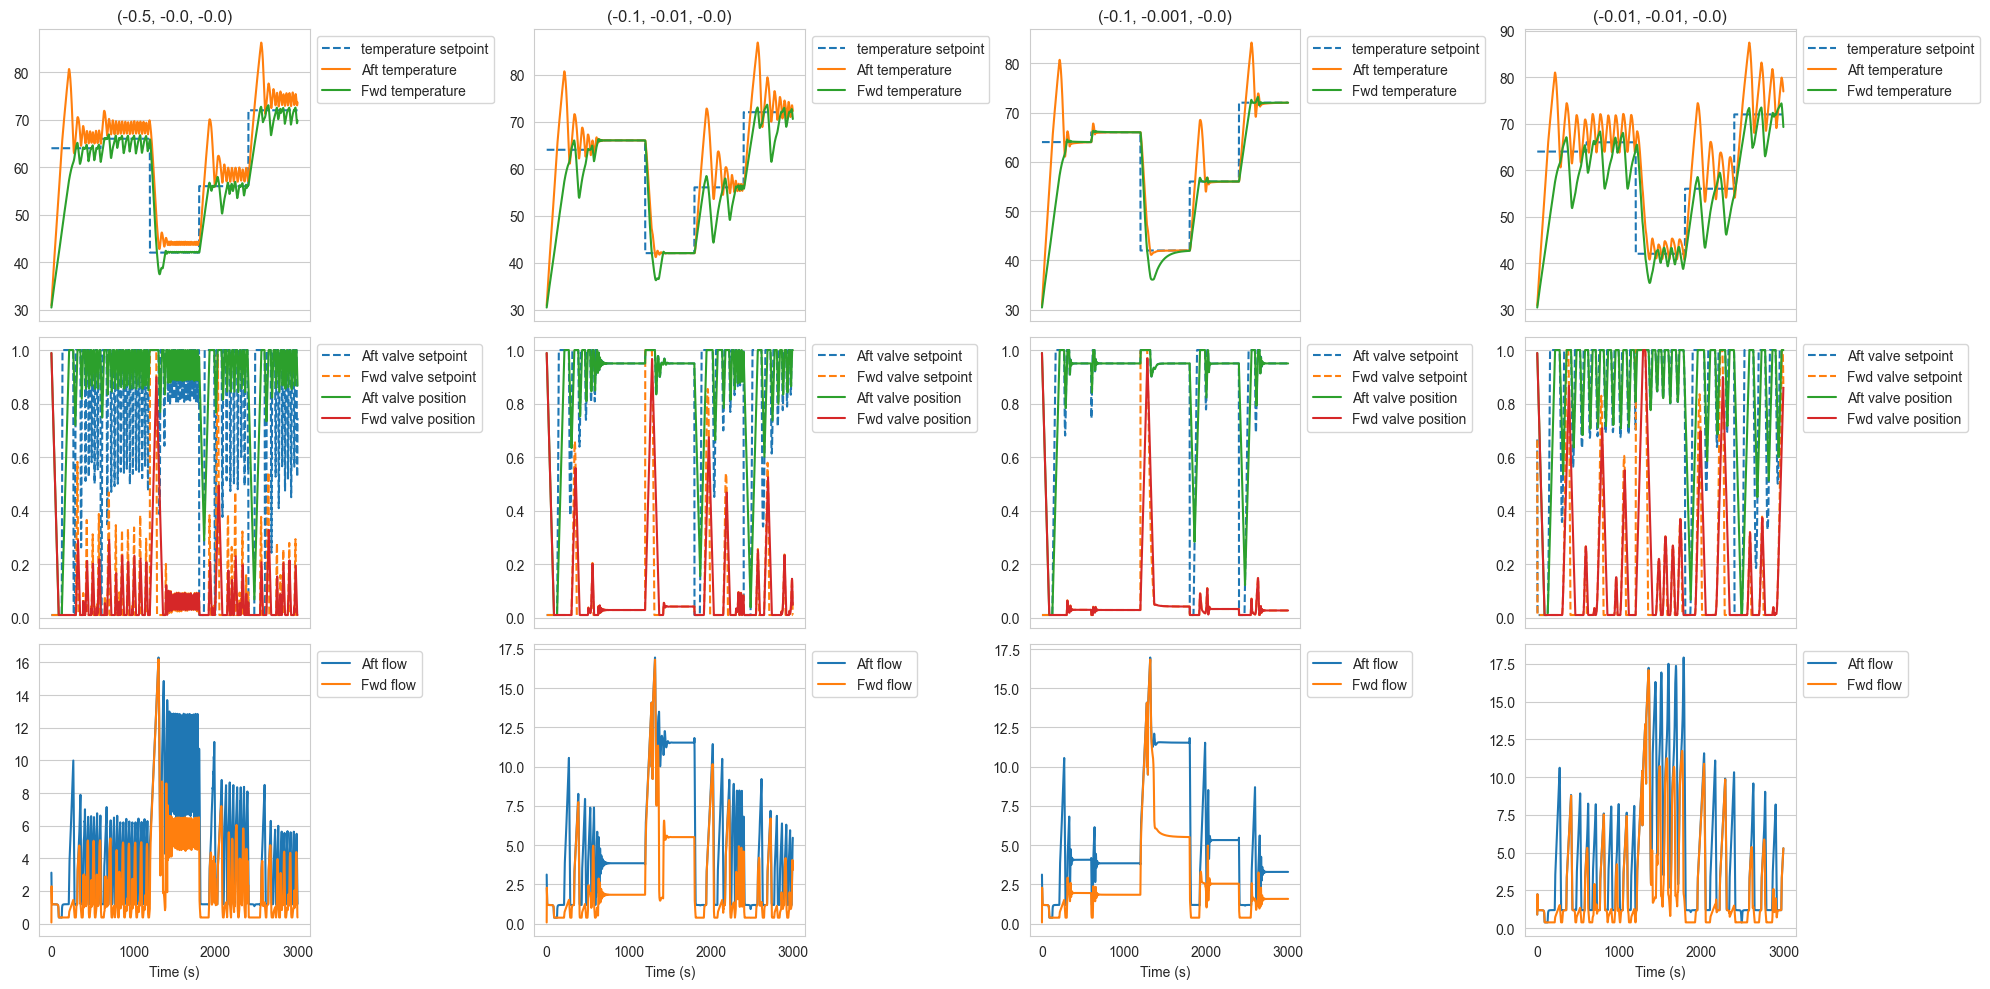

In [125]:
plot_flow_test(results)
